C:\Users\Satwik\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\Satwik\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\Satwik\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


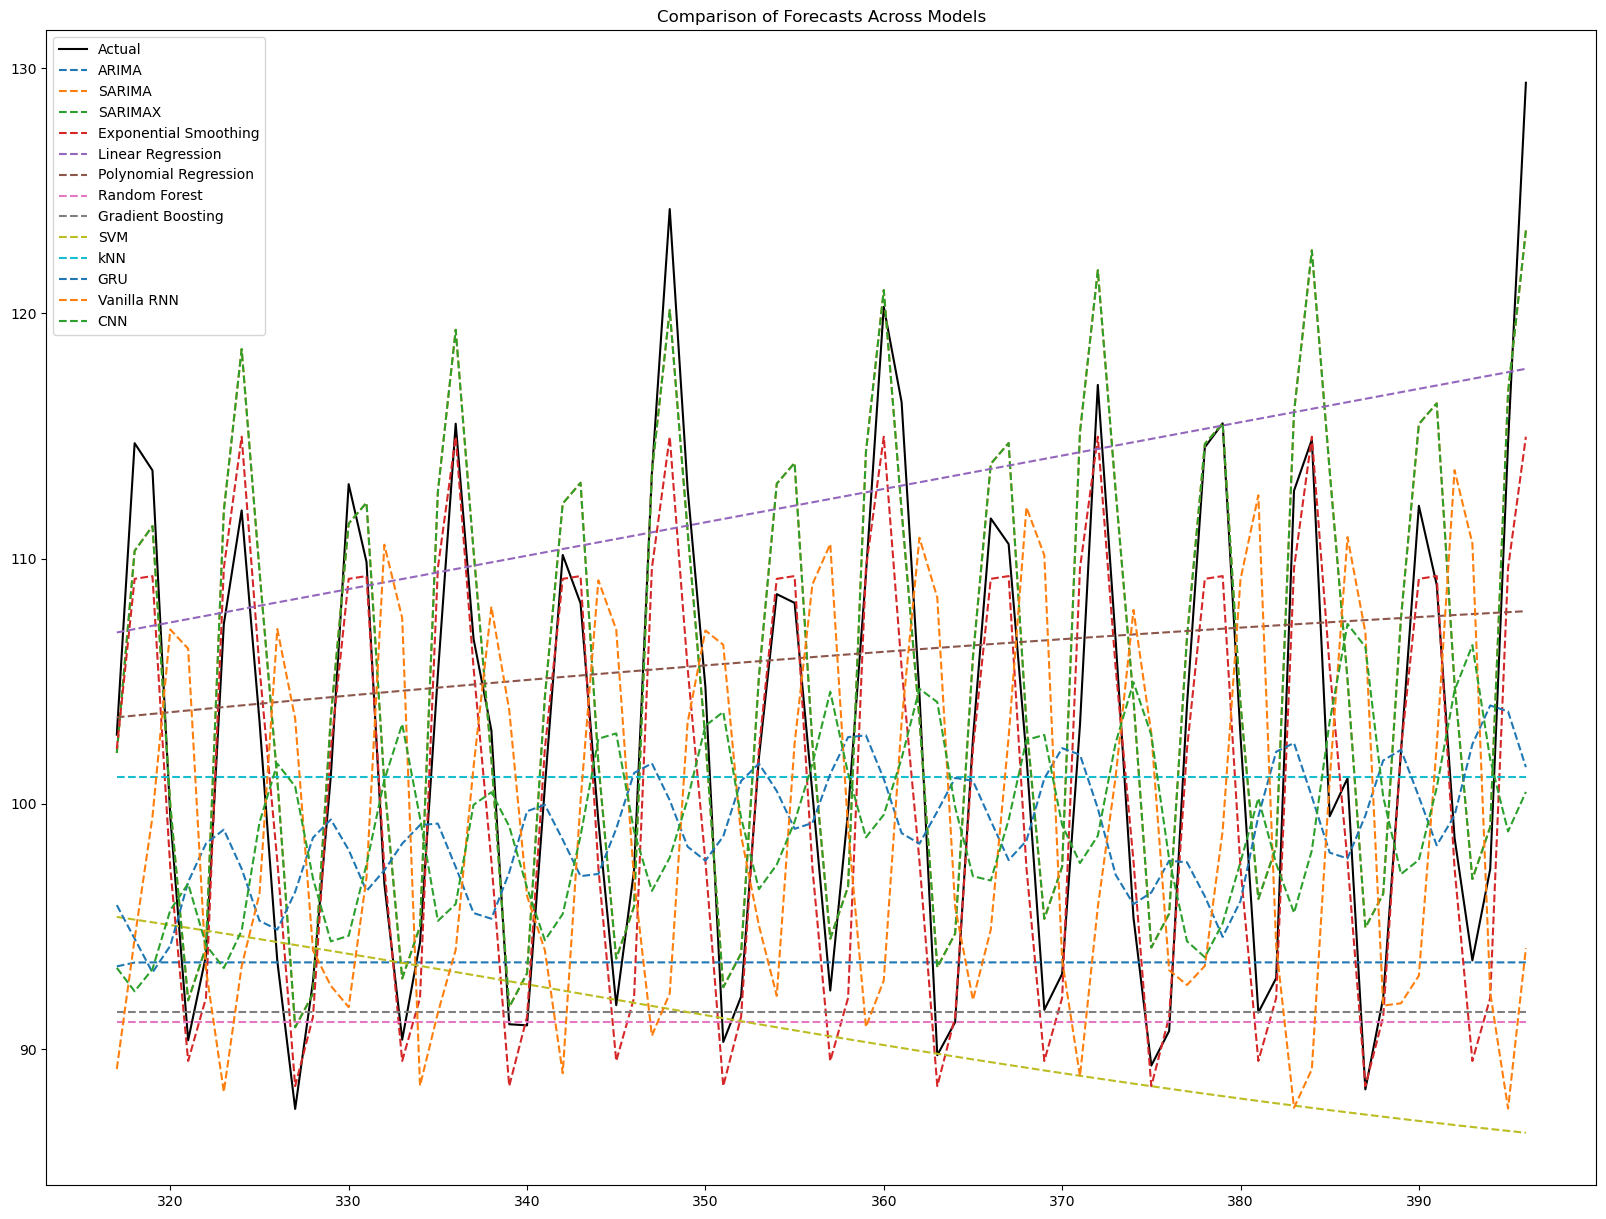

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# Load the dataset
data = pd.read_csv(r"archive\Electric_Production.csv")
data = data.dropna()
data['Value'] = data['Value'].astype(float)  # Ensure numeric data

# Train-test split
data_len = len(data)
train_size = int(data_len * 0.8)
train, test = data['Value'][:train_size], data['Value'][train_size:]

# 1. ARIMA
model_arima = ARIMA(train, order=(1, 1, 1))
result_arima = model_arima.fit()
forecast_arima = result_arima.forecast(steps=len(test))

# 2. SARIMA
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result_sarima = model_sarima.fit()
forecast_sarima = result_sarima.forecast(steps=len(test))

# 3. SARIMAX
exog = np.arange(len(train)).reshape(-1, 1)  # Example exogenous variable
model_sarimax = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=exog)
result_sarimax = model_sarimax.fit()
forecast_sarimax = result_sarimax.forecast(steps=len(test), exog=np.arange(len(test)).reshape(-1, 1))

# 4. Exponential Smoothing
model_ets = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit()
forecast_ets = model_ets.forecast(len(test))

# 5. Linear Regression
X = np.arange(len(train)).reshape(-1, 1)
y = train.values
lr_model = LinearRegression()
lr_model.fit(X, y)
forecast_lr = lr_model.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1))

# 6. Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
forecast_poly = poly_model.predict(poly.fit_transform(np.arange(len(train), len(train) + len(test)).reshape(-1, 1)))

# 7. Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X, y)
forecast_rf = rf_model.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1))

# 8. Gradient Boosting
gb_model = GradientBoostingRegressor()
gb_model.fit(X, y)
forecast_gb = gb_model.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1))

# 9. Support Vector Machines (SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
svr_model = SVR()
svr_model.fit(X_scaled, y)
forecast_svr = svr_model.predict(scaler.transform(np.arange(len(train), len(train) + len(test)).reshape(-1, 1)))

# 10. k-Nearest Neighbors (kNN)
knn_model = KNeighborsRegressor()
knn_model.fit(X, y)
forecast_knn = knn_model.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1))

# Neural Network Models
# Preprocessing for LSTM, GRU, Vanilla RNN
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
X_train, y_train = [], []
for i in range(10, len(train_scaled)):
    X_train.append(train_scaled[i-10:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# 11. GRU
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
forecast_gru = scaler.inverse_transform(model_gru.predict(X_train))[-len(test):, 0]

# 12. Vanilla RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
forecast_rnn = scaler.inverse_transform(model_rnn.predict(X_train))[-len(test):, 0]

# 13. CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='adam', loss='mean_squared_error')
model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
forecast_cnn = scaler.inverse_transform(model_cnn.predict(X_train))[-len(test):, 0]

# Plot all forecasts
plt.figure(figsize=(20, 15))
plt.plot(test.index, test.values, label='Actual', color='black')
plt.plot(test.index, forecast_arima, label='ARIMA', linestyle='--')
plt.plot(test.index, forecast_sarima, label='SARIMA', linestyle='--')
plt.plot(test.index, forecast_sarimax, label='SARIMAX', linestyle='--')
plt.plot(test.index, forecast_ets, label='Exponential Smoothing', linestyle='--')
plt.plot(test.index, forecast_lr, label='Linear Regression', linestyle='--')
plt.plot(test.index, forecast_poly, label='Polynomial Regression', linestyle='--')
plt.plot(test.index, forecast_rf, label='Random Forest', linestyle='--')
plt.plot(test.index, forecast_gb, label='Gradient Boosting', linestyle='--')
plt.plot(test.index, forecast_svr, label='SVM', linestyle='--')
plt.plot(test.index, forecast_knn, label='kNN', linestyle='--')
plt.plot(test.index, forecast_gru, label='GRU', linestyle='--')
plt.plot(test.index, forecast_rnn, label='Vanilla RNN', linestyle='--')
plt.plot(test.index, forecast_cnn, label='CNN', linestyle='--')
plt.legend()
plt.title('Comparison of Forecasts Across Models')
plt.show()
